<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:15:59] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


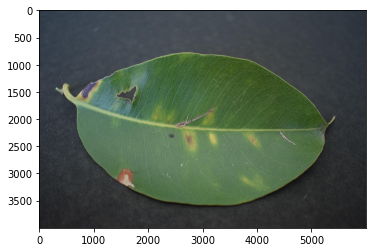

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

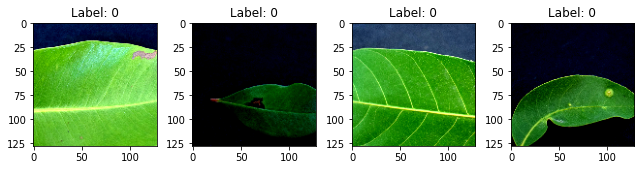

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:16:04] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:16:06] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2404665638047208 samples/sec                   batch loss = 0.6826515197753906 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.3008046168083782 samples/sec                   batch loss = 2.421405076980591 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2977446822894747 samples/sec                   batch loss = 1.0625782012939453 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.2939505025764917 samples/sec                   batch loss = 0.46758773922920227 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.297073770594463 samples/sec                   batch loss = 0.7890968322753906 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.3003195767230213 samples/sec                   batch loss = 0.7574735283851624 | accuracy = 0.5583333333333333


Epoch[1] Batch[35] Speed: 1.2994239452162422 samples/sec                   batch loss = 0.6690095067024231 | accuracy = 0.5571428571428572


Epoch[1] Batch[40] Speed: 1.2991086078600904 samples/sec                   batch loss = 1.2665479183197021 | accuracy = 0.55


Epoch[1] Batch[45] Speed: 1.2920539589041717 samples/sec                   batch loss = 0.391539990901947 | accuracy = 0.5555555555555556


Epoch[1] Batch[50] Speed: 1.2942126213458172 samples/sec                   batch loss = 0.8872266411781311 | accuracy = 0.56


Epoch[1] Batch[55] Speed: 1.2969180561955544 samples/sec                   batch loss = 0.42119425535202026 | accuracy = 0.5772727272727273


Epoch[1] Batch[60] Speed: 1.3045328453145815 samples/sec                   batch loss = 0.6378924250602722 | accuracy = 0.5875


Epoch[1] Batch[65] Speed: 1.293790448746022 samples/sec                   batch loss = 0.9423419833183289 | accuracy = 0.5923076923076923


Epoch[1] Batch[70] Speed: 1.3024868584595344 samples/sec                   batch loss = 0.3914524018764496 | accuracy = 0.6071428571428571


Epoch[1] Batch[75] Speed: 1.3039717424870447 samples/sec                   batch loss = 0.9447795152664185 | accuracy = 0.5966666666666667


Epoch[1] Batch[80] Speed: 1.2917973885347278 samples/sec                   batch loss = 0.49363112449645996 | accuracy = 0.590625


Epoch[1] Batch[85] Speed: 1.2953894704267095 samples/sec                   batch loss = 0.7045013904571533 | accuracy = 0.5941176470588235


Epoch[1] Batch[90] Speed: 1.2946284760427367 samples/sec                   batch loss = 0.5056604146957397 | accuracy = 0.6027777777777777


Epoch[1] Batch[95] Speed: 1.293936531213455 samples/sec                   batch loss = 0.5617966651916504 | accuracy = 0.6078947368421053


Epoch[1] Batch[100] Speed: 1.295057593697102 samples/sec                   batch loss = 0.824586033821106 | accuracy = 0.605


Epoch[1] Batch[105] Speed: 1.297824792582389 samples/sec                   batch loss = 1.2043371200561523 | accuracy = 0.6023809523809524


Epoch[1] Batch[110] Speed: 1.29542617829798 samples/sec                   batch loss = 0.26439526677131653 | accuracy = 0.6045454545454545


Epoch[1] Batch[115] Speed: 1.2992557931991182 samples/sec                   batch loss = 0.28982359170913696 | accuracy = 0.6108695652173913


Epoch[1] Batch[120] Speed: 1.2976094809582495 samples/sec                   batch loss = 0.5555773377418518 | accuracy = 0.6166666666666667


Epoch[1] Batch[125] Speed: 1.2946100944952115 samples/sec                   batch loss = 0.7500531077384949 | accuracy = 0.622


Epoch[1] Batch[130] Speed: 1.303477856661547 samples/sec                   batch loss = 0.8748123645782471 | accuracy = 0.6230769230769231


Epoch[1] Batch[135] Speed: 1.2945156974886085 samples/sec                   batch loss = 0.5541709661483765 | accuracy = 0.6296296296296297


Epoch[1] Batch[140] Speed: 1.3018712421920353 samples/sec                   batch loss = 1.7321927547454834 | accuracy = 0.6303571428571428


Epoch[1] Batch[145] Speed: 1.2984045315801087 samples/sec                   batch loss = 0.2514268457889557 | accuracy = 0.6327586206896552


Epoch[1] Batch[150] Speed: 1.2961092039641875 samples/sec                   batch loss = 0.7309654951095581 | accuracy = 0.6333333333333333


Epoch[1] Batch[155] Speed: 1.3058820132071642 samples/sec                   batch loss = 0.3274742364883423 | accuracy = 0.6370967741935484


Epoch[1] Batch[160] Speed: 1.3044971409821586 samples/sec                   batch loss = 0.581725537776947 | accuracy = 0.6359375


Epoch[1] Batch[165] Speed: 1.2975790720677292 samples/sec                   batch loss = 0.1603473722934723 | accuracy = 0.6378787878787879


Epoch[1] Batch[170] Speed: 1.295230060376383 samples/sec                   batch loss = 0.48581254482269287 | accuracy = 0.6397058823529411


Epoch[1] Batch[175] Speed: 1.2979776118184767 samples/sec                   batch loss = 0.5361055731773376 | accuracy = 0.6428571428571429


Epoch[1] Batch[180] Speed: 1.300140512870427 samples/sec                   batch loss = 0.3601743280887604 | accuracy = 0.6472222222222223


Epoch[1] Batch[185] Speed: 1.3027993868527437 samples/sec                   batch loss = 0.8905768990516663 | accuracy = 0.65


Epoch[1] Batch[190] Speed: 1.300353641722267 samples/sec                   batch loss = 0.3739670515060425 | accuracy = 0.6513157894736842


Epoch[1] Batch[195] Speed: 1.296905223708053 samples/sec                   batch loss = 0.8377406001091003 | accuracy = 0.6487179487179487


Epoch[1] Batch[200] Speed: 1.2986282491702454 samples/sec                   batch loss = 0.35389018058776855 | accuracy = 0.65


Epoch[1] Batch[205] Speed: 1.3006467954086527 samples/sec                   batch loss = 0.5152481198310852 | accuracy = 0.6475609756097561


Epoch[1] Batch[210] Speed: 1.2948909695310529 samples/sec                   batch loss = 1.4842255115509033 | accuracy = 0.6452380952380953


Epoch[1] Batch[215] Speed: 1.2927750700510632 samples/sec                   batch loss = 1.291744589805603 | accuracy = 0.6441860465116279


Epoch[1] Batch[220] Speed: 1.296614054660965 samples/sec                   batch loss = 0.3277551829814911 | accuracy = 0.6488636363636363


Epoch[1] Batch[225] Speed: 1.2942674341603826 samples/sec                   batch loss = 0.7036401629447937 | accuracy = 0.6522222222222223


Epoch[1] Batch[230] Speed: 1.295243559706856 samples/sec                   batch loss = 0.7006285786628723 | accuracy = 0.65


Epoch[1] Batch[235] Speed: 1.2991268155851396 samples/sec                   batch loss = 0.6946278214454651 | accuracy = 0.648936170212766


Epoch[1] Batch[240] Speed: 1.3000525609047449 samples/sec                   batch loss = 1.079140067100525 | accuracy = 0.6479166666666667


Epoch[1] Batch[245] Speed: 1.2953615658347053 samples/sec                   batch loss = 0.557745099067688 | accuracy = 0.6510204081632653


Epoch[1] Batch[250] Speed: 1.3025651281942985 samples/sec                   batch loss = 0.7101332545280457 | accuracy = 0.65


Epoch[1] Batch[255] Speed: 1.2984054359434736 samples/sec                   batch loss = 0.7831470966339111 | accuracy = 0.6480392156862745


Epoch[1] Batch[260] Speed: 1.3094144728513648 samples/sec                   batch loss = 1.053711175918579 | accuracy = 0.6471153846153846


Epoch[1] Batch[265] Speed: 1.3023818057345204 samples/sec                   batch loss = 0.42867496609687805 | accuracy = 0.6471698113207547


Epoch[1] Batch[270] Speed: 1.3016746829667312 samples/sec                   batch loss = 0.5091671347618103 | accuracy = 0.6481481481481481


Epoch[1] Batch[275] Speed: 1.3023834233573486 samples/sec                   batch loss = 0.8382895588874817 | accuracy = 0.649090909090909


Epoch[1] Batch[280] Speed: 1.2956523726883673 samples/sec                   batch loss = 0.3636155128479004 | accuracy = 0.6517857142857143


Epoch[1] Batch[285] Speed: 1.2970195219914147 samples/sec                   batch loss = 0.2532406449317932 | accuracy = 0.6543859649122807


Epoch[1] Batch[290] Speed: 1.291157153435702 samples/sec                   batch loss = 0.82155841588974 | accuracy = 0.6551724137931034


Epoch[1] Batch[295] Speed: 1.299295739198141 samples/sec                   batch loss = 0.49080783128738403 | accuracy = 0.6559322033898305


Epoch[1] Batch[300] Speed: 1.2998140523608284 samples/sec                   batch loss = 0.7109696269035339 | accuracy = 0.6566666666666666


Epoch[1] Batch[305] Speed: 1.2997442689042298 samples/sec                   batch loss = 0.49689769744873047 | accuracy = 0.6573770491803279


Epoch[1] Batch[310] Speed: 1.2974729030251835 samples/sec                   batch loss = 0.5320215821266174 | accuracy = 0.657258064516129


Epoch[1] Batch[315] Speed: 1.2968106921928781 samples/sec                   batch loss = 0.5986368656158447 | accuracy = 0.6547619047619048


Epoch[1] Batch[320] Speed: 1.2983209336522976 samples/sec                   batch loss = 0.7418109178543091 | accuracy = 0.65234375


Epoch[1] Batch[325] Speed: 1.2949217522905316 samples/sec                   batch loss = 0.2906297445297241 | accuracy = 0.6530769230769231


Epoch[1] Batch[330] Speed: 1.296701040871874 samples/sec                   batch loss = 0.6070098876953125 | accuracy = 0.6553030303030303


Epoch[1] Batch[335] Speed: 1.3024158777643668 samples/sec                   batch loss = 0.3921718895435333 | accuracy = 0.6567164179104478


Epoch[1] Batch[340] Speed: 1.2977360494397268 samples/sec                   batch loss = 0.538762092590332 | accuracy = 0.6595588235294118


Epoch[1] Batch[345] Speed: 1.3018217432702766 samples/sec                   batch loss = 0.5213524103164673 | accuracy = 0.6594202898550725


Epoch[1] Batch[350] Speed: 1.3015929859339463 samples/sec                   batch loss = 0.5892431139945984 | accuracy = 0.6614285714285715


Epoch[1] Batch[355] Speed: 1.3016840752482726 samples/sec                   batch loss = 0.15558511018753052 | accuracy = 0.6647887323943662


Epoch[1] Batch[360] Speed: 1.2982083145237284 samples/sec                   batch loss = 0.3332573473453522 | accuracy = 0.6673611111111111


Epoch[1] Batch[365] Speed: 1.2997159750056766 samples/sec                   batch loss = 0.32497289776802063 | accuracy = 0.6678082191780822


Epoch[1] Batch[370] Speed: 1.2976407945725792 samples/sec                   batch loss = 0.580642819404602 | accuracy = 0.6695945945945946


Epoch[1] Batch[375] Speed: 1.2992612265156156 samples/sec                   batch loss = 0.6699051856994629 | accuracy = 0.6706666666666666


Epoch[1] Batch[380] Speed: 1.2982893862707492 samples/sec                   batch loss = 0.4290628433227539 | accuracy = 0.6710526315789473


Epoch[1] Batch[385] Speed: 1.2970792859561064 samples/sec                   batch loss = 0.4276118278503418 | accuracy = 0.6733766233766234


Epoch[1] Batch[390] Speed: 1.3035357865576012 samples/sec                   batch loss = 0.34611964225769043 | accuracy = 0.6743589743589744


Epoch[1] Batch[395] Speed: 1.3028379322938357 samples/sec                   batch loss = 0.4785289168357849 | accuracy = 0.6740506329113924


Epoch[1] Batch[400] Speed: 1.3061350577799866 samples/sec                   batch loss = 0.8114474415779114 | accuracy = 0.675


Epoch[1] Batch[405] Speed: 1.2983584107189456 samples/sec                   batch loss = 0.8469640016555786 | accuracy = 0.674074074074074


Epoch[1] Batch[410] Speed: 1.2995550957558457 samples/sec                   batch loss = 0.701816976070404 | accuracy = 0.6743902439024391


Epoch[1] Batch[415] Speed: 1.292055948991209 samples/sec                   batch loss = 0.3956802189350128 | accuracy = 0.6740963855421687


Epoch[1] Batch[420] Speed: 1.2962978759439512 samples/sec                   batch loss = 0.3121182918548584 | accuracy = 0.674404761904762


Epoch[1] Batch[425] Speed: 1.2962311735218388 samples/sec                   batch loss = 0.9791909456253052 | accuracy = 0.6741176470588235


Epoch[1] Batch[430] Speed: 1.2993680909758163 samples/sec                   batch loss = 0.4057164490222931 | accuracy = 0.6761627906976744


Epoch[1] Batch[435] Speed: 1.296864622588421 samples/sec                   batch loss = 0.49897998571395874 | accuracy = 0.6781609195402298


Epoch[1] Batch[440] Speed: 1.295680890192439 samples/sec                   batch loss = 0.14813855290412903 | accuracy = 0.6795454545454546


Epoch[1] Batch[445] Speed: 1.29860221517307 samples/sec                   batch loss = 0.5447586178779602 | accuracy = 0.6797752808988764


Epoch[1] Batch[450] Speed: 1.3040636718748482 samples/sec                   batch loss = 0.11281789094209671 | accuracy = 0.6822222222222222


Epoch[1] Batch[455] Speed: 1.3008790532247072 samples/sec                   batch loss = 0.3795161843299866 | accuracy = 0.6818681318681319


Epoch[1] Batch[460] Speed: 1.3083109702142983 samples/sec                   batch loss = 0.1860063672065735 | accuracy = 0.6831521739130435


Epoch[1] Batch[465] Speed: 1.2977373543980175 samples/sec                   batch loss = 0.6468916535377502 | accuracy = 0.6833333333333333


Epoch[1] Batch[470] Speed: 1.3048833992766573 samples/sec                   batch loss = 0.5459273457527161 | accuracy = 0.6829787234042554


Epoch[1] Batch[475] Speed: 1.2966337958993142 samples/sec                   batch loss = 0.8105413317680359 | accuracy = 0.6821052631578948


Epoch[1] Batch[480] Speed: 1.301449308864612 samples/sec                   batch loss = 0.27871444821357727 | accuracy = 0.6838541666666667


Epoch[1] Batch[485] Speed: 1.3018429566329779 samples/sec                   batch loss = 0.4463557004928589 | accuracy = 0.684020618556701


Epoch[1] Batch[490] Speed: 1.2966137540376166 samples/sec                   batch loss = 0.7492116093635559 | accuracy = 0.6836734693877551


Epoch[1] Batch[495] Speed: 1.2965305869320023 samples/sec                   batch loss = 0.45773065090179443 | accuracy = 0.6833333333333333


Epoch[1] Batch[500] Speed: 1.2988545577231498 samples/sec                   batch loss = 0.8291367888450623 | accuracy = 0.683


Epoch[1] Batch[505] Speed: 1.3003307635525785 samples/sec                   batch loss = 0.2553017735481262 | accuracy = 0.6836633663366337


Epoch[1] Batch[510] Speed: 1.295711610452181 samples/sec                   batch loss = 0.3502303659915924 | accuracy = 0.6848039215686275


Epoch[1] Batch[515] Speed: 1.2957588444423573 samples/sec                   batch loss = 0.47530022263526917 | accuracy = 0.6864077669902913


Epoch[1] Batch[520] Speed: 1.2964272942148112 samples/sec                   batch loss = 0.42189323902130127 | accuracy = 0.6865384615384615


Epoch[1] Batch[525] Speed: 1.2960691532869226 samples/sec                   batch loss = 0.37030792236328125 | accuracy = 0.6861904761904762


Epoch[1] Batch[530] Speed: 1.3010989829115176 samples/sec                   batch loss = 1.053999662399292 | accuracy = 0.685377358490566


Epoch[1] Batch[535] Speed: 1.2949869206229627 samples/sec                   batch loss = 0.24042683839797974 | accuracy = 0.6855140186915888


Epoch[1] Batch[540] Speed: 1.293096508907892 samples/sec                   batch loss = 0.3554149270057678 | accuracy = 0.6842592592592592


Epoch[1] Batch[545] Speed: 1.292595687792351 samples/sec                   batch loss = 0.43447041511535645 | accuracy = 0.6839449541284404


Epoch[1] Batch[550] Speed: 1.2910274936759552 samples/sec                   batch loss = 0.2363400012254715 | accuracy = 0.6836363636363636


Epoch[1] Batch[555] Speed: 1.2981322750123239 samples/sec                   batch loss = 0.6774790287017822 | accuracy = 0.6837837837837838


Epoch[1] Batch[560] Speed: 1.2963180082037014 samples/sec                   batch loss = 0.6324295997619629 | accuracy = 0.684375


Epoch[1] Batch[565] Speed: 1.2969639745199375 samples/sec                   batch loss = 0.3899366557598114 | accuracy = 0.6845132743362832


Epoch[1] Batch[570] Speed: 1.2956485704493372 samples/sec                   batch loss = 0.630107581615448 | accuracy = 0.6846491228070175


Epoch[1] Batch[575] Speed: 1.2969197605294043 samples/sec                   batch loss = 0.5752576589584351 | accuracy = 0.6834782608695652


Epoch[1] Batch[580] Speed: 1.2933874960480765 samples/sec                   batch loss = 0.45812931656837463 | accuracy = 0.6836206896551724


Epoch[1] Batch[585] Speed: 1.2931882070646925 samples/sec                   batch loss = 1.3401410579681396 | accuracy = 0.6846153846153846


Epoch[1] Batch[590] Speed: 1.302379177105995 samples/sec                   batch loss = 0.500601589679718 | accuracy = 0.6860169491525424


Epoch[1] Batch[595] Speed: 1.2996726806773147 samples/sec                   batch loss = 0.38940897583961487 | accuracy = 0.6869747899159664


Epoch[1] Batch[600] Speed: 1.298932894337811 samples/sec                   batch loss = 0.9588560461997986 | accuracy = 0.6858333333333333


Epoch[1] Batch[605] Speed: 1.3017608344569802 samples/sec                   batch loss = 0.596589207649231 | accuracy = 0.6851239669421487


Epoch[1] Batch[610] Speed: 1.297463270399016 samples/sec                   batch loss = 0.26384565234184265 | accuracy = 0.6860655737704918


Epoch[1] Batch[615] Speed: 1.294682125174402 samples/sec                   batch loss = 0.506868302822113 | accuracy = 0.6865853658536586


Epoch[1] Batch[620] Speed: 1.294089134804911 samples/sec                   batch loss = 0.4265848994255066 | accuracy = 0.6870967741935484


Epoch[1] Batch[625] Speed: 1.289798362145532 samples/sec                   batch loss = 0.42788031697273254 | accuracy = 0.688


Epoch[1] Batch[630] Speed: 1.2936889887410332 samples/sec                   batch loss = 0.7370099425315857 | accuracy = 0.6873015873015873


Epoch[1] Batch[635] Speed: 1.2992245022052535 samples/sec                   batch loss = 0.23841926455497742 | accuracy = 0.6866141732283465


Epoch[1] Batch[640] Speed: 1.2997657167015149 samples/sec                   batch loss = 0.6296802163124084 | accuracy = 0.687109375


Epoch[1] Batch[645] Speed: 1.3028640352263434 samples/sec                   batch loss = 0.49013784527778625 | accuracy = 0.6868217054263566


Epoch[1] Batch[650] Speed: 1.2995226831060587 samples/sec                   batch loss = 1.4596847295761108 | accuracy = 0.686923076923077


Epoch[1] Batch[655] Speed: 1.3040439064694576 samples/sec                   batch loss = 0.48912572860717773 | accuracy = 0.6877862595419847


Epoch[1] Batch[660] Speed: 1.2945745316786266 samples/sec                   batch loss = 0.5896155834197998 | accuracy = 0.6882575757575757


Epoch[1] Batch[665] Speed: 1.2986174936857986 samples/sec                   batch loss = 0.29552748799324036 | accuracy = 0.6890977443609022


Epoch[1] Batch[670] Speed: 1.2984368884754045 samples/sec                   batch loss = 0.44910910725593567 | accuracy = 0.6895522388059702


Epoch[1] Batch[675] Speed: 1.3022967850908072 samples/sec                   batch loss = 0.23560740053653717 | accuracy = 0.6907407407407408


Epoch[1] Batch[680] Speed: 1.2962284695143769 samples/sec                   batch loss = 0.2415502369403839 | accuracy = 0.6922794117647059


Epoch[1] Batch[685] Speed: 1.2974029693960059 samples/sec                   batch loss = 0.2773136496543884 | accuracy = 0.6923357664233577


Epoch[1] Batch[690] Speed: 1.3010354176101644 samples/sec                   batch loss = 0.3586506247520447 | accuracy = 0.6931159420289855


Epoch[1] Batch[695] Speed: 1.2960549358918005 samples/sec                   batch loss = 0.29374703764915466 | accuracy = 0.6942446043165468


Epoch[1] Batch[700] Speed: 1.2939805420287214 samples/sec                   batch loss = 0.34556490182876587 | accuracy = 0.6946428571428571


Epoch[1] Batch[705] Speed: 1.2999701608116074 samples/sec                   batch loss = 1.051964521408081 | accuracy = 0.6939716312056737


Epoch[1] Batch[710] Speed: 1.295842913451753 samples/sec                   batch loss = 0.45602142810821533 | accuracy = 0.6940140845070423


Epoch[1] Batch[715] Speed: 1.2918448349317369 samples/sec                   batch loss = 0.8314616680145264 | accuracy = 0.6923076923076923


Epoch[1] Batch[720] Speed: 1.2920721684291463 samples/sec                   batch loss = 1.1030551195144653 | accuracy = 0.6920138888888889


Epoch[1] Batch[725] Speed: 1.2915424114219007 samples/sec                   batch loss = 0.5414615869522095 | accuracy = 0.6917241379310345


Epoch[1] Batch[730] Speed: 1.2873402911375778 samples/sec                   batch loss = 0.3919914960861206 | accuracy = 0.6907534246575342


Epoch[1] Batch[735] Speed: 1.294679027990003 samples/sec                   batch loss = 0.23173050582408905 | accuracy = 0.6921768707482994


Epoch[1] Batch[740] Speed: 1.297794674770746 samples/sec                   batch loss = 1.4990102052688599 | accuracy = 0.6925675675675675


Epoch[1] Batch[745] Speed: 1.2942780178615318 samples/sec                   batch loss = 0.5580037832260132 | accuracy = 0.6926174496644295


Epoch[1] Batch[750] Speed: 1.2892701704362943 samples/sec                   batch loss = 0.5370960235595703 | accuracy = 0.693


Epoch[1] Batch[755] Speed: 1.2888003257103788 samples/sec                   batch loss = 0.5715956687927246 | accuracy = 0.6923841059602649


Epoch[1] Batch[760] Speed: 1.286795456536142 samples/sec                   batch loss = 0.41375213861465454 | accuracy = 0.6921052631578948


Epoch[1] Batch[765] Speed: 1.2945698367336735 samples/sec                   batch loss = 0.17434626817703247 | accuracy = 0.6915032679738562


Epoch[1] Batch[770] Speed: 1.2962097420686305 samples/sec                   batch loss = 0.8724011182785034 | accuracy = 0.6922077922077922


Epoch[1] Batch[775] Speed: 1.2960037758746483 samples/sec                   batch loss = 0.7760223746299744 | accuracy = 0.6925806451612904


Epoch[1] Batch[780] Speed: 1.2913309681686436 samples/sec                   batch loss = 0.41402196884155273 | accuracy = 0.6926282051282051


Epoch[1] Batch[785] Speed: 1.2982213737244677 samples/sec                   batch loss = 0.5596371293067932 | accuracy = 0.6936305732484076


[Epoch 1] training: accuracy=0.6935279187817259
[Epoch 1] time cost: 634.0772564411163
[Epoch 1] validation: validation accuracy=0.7344444444444445


Epoch[2] Batch[5] Speed: 1.2942135198791167 samples/sec                   batch loss = 0.7547430992126465 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.297929713875825 samples/sec                   batch loss = 0.9857382774353027 | accuracy = 0.625


Epoch[2] Batch[15] Speed: 1.3001729563477025 samples/sec                   batch loss = 0.3764628469944 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.3028352006520538 samples/sec                   batch loss = 0.7710182666778564 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2982254924499685 samples/sec                   batch loss = 0.254072368144989 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.3014502174744418 samples/sec                   batch loss = 0.2472599297761917 | accuracy = 0.725


Epoch[2] Batch[35] Speed: 1.3042843755786877 samples/sec                   batch loss = 0.23905818164348602 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.30290946491703 samples/sec                   batch loss = 0.3182523548603058 | accuracy = 0.76875


Epoch[2] Batch[45] Speed: 1.2988893504831696 samples/sec                   batch loss = 0.8334377408027649 | accuracy = 0.7555555555555555


Epoch[2] Batch[50] Speed: 1.2995852953317393 samples/sec                   batch loss = 1.1787636280059814 | accuracy = 0.765


Epoch[2] Batch[55] Speed: 1.3041277361785966 samples/sec                   batch loss = 0.6710821390151978 | accuracy = 0.7681818181818182


Epoch[2] Batch[60] Speed: 1.2948760783966866 samples/sec                   batch loss = 0.7278519868850708 | accuracy = 0.7583333333333333


Epoch[2] Batch[65] Speed: 1.296534895327233 samples/sec                   batch loss = 0.6202133893966675 | accuracy = 0.7653846153846153


Epoch[2] Batch[70] Speed: 1.2958363076347001 samples/sec                   batch loss = 0.37643295526504517 | accuracy = 0.7642857142857142


Epoch[2] Batch[75] Speed: 1.2975213693457581 samples/sec                   batch loss = 0.6094762086868286 | accuracy = 0.76


Epoch[2] Batch[80] Speed: 1.292698669632405 samples/sec                   batch loss = 0.453387975692749 | accuracy = 0.75


Epoch[2] Batch[85] Speed: 1.2965023325845395 samples/sec                   batch loss = 0.699491024017334 | accuracy = 0.7382352941176471


Epoch[2] Batch[90] Speed: 1.2971283245975258 samples/sec                   batch loss = 1.0026789903640747 | accuracy = 0.7333333333333333


Epoch[2] Batch[95] Speed: 1.2958672354495648 samples/sec                   batch loss = 0.7752757668495178 | accuracy = 0.7289473684210527


Epoch[2] Batch[100] Speed: 1.2989066469997013 samples/sec                   batch loss = 0.44014522433280945 | accuracy = 0.725


Epoch[2] Batch[105] Speed: 1.2976083769801963 samples/sec                   batch loss = 0.5338870882987976 | accuracy = 0.7214285714285714


Epoch[2] Batch[110] Speed: 1.295433280060931 samples/sec                   batch loss = 0.6113274097442627 | accuracy = 0.7272727272727273


Epoch[2] Batch[115] Speed: 1.301939738744714 samples/sec                   batch loss = 0.5379456281661987 | accuracy = 0.7260869565217392


Epoch[2] Batch[120] Speed: 1.3003802499454145 samples/sec                   batch loss = 0.46407514810562134 | accuracy = 0.7229166666666667


Epoch[2] Batch[125] Speed: 1.3013663278493386 samples/sec                   batch loss = 0.9884921908378601 | accuracy = 0.722


Epoch[2] Batch[130] Speed: 1.2928199981120772 samples/sec                   batch loss = 0.16652347147464752 | accuracy = 0.7192307692307692


Epoch[2] Batch[135] Speed: 1.2964294981552564 samples/sec                   batch loss = 0.5074812173843384 | accuracy = 0.7240740740740741


Epoch[2] Batch[140] Speed: 1.2975494674214636 samples/sec                   batch loss = 0.6257591843605042 | accuracy = 0.725


Epoch[2] Batch[145] Speed: 1.2988625015706226 samples/sec                   batch loss = 0.24443820118904114 | accuracy = 0.7241379310344828


Epoch[2] Batch[150] Speed: 1.2986362907703421 samples/sec                   batch loss = 0.6240086555480957 | accuracy = 0.7266666666666667


Epoch[2] Batch[155] Speed: 1.2968308403845719 samples/sec                   batch loss = 0.3414590358734131 | accuracy = 0.7290322580645161


Epoch[2] Batch[160] Speed: 1.2965768786308534 samples/sec                   batch loss = 0.3948014974594116 | accuracy = 0.73125


Epoch[2] Batch[165] Speed: 1.3018892243650744 samples/sec                   batch loss = 0.4676224887371063 | accuracy = 0.7333333333333333


Epoch[2] Batch[170] Speed: 1.29812755422671 samples/sec                   batch loss = 0.7640351057052612 | accuracy = 0.7338235294117647


Epoch[2] Batch[175] Speed: 1.305496281013697 samples/sec                   batch loss = 0.4438004791736603 | accuracy = 0.7385714285714285


Epoch[2] Batch[180] Speed: 1.3044612357552599 samples/sec                   batch loss = 0.7334092259407043 | accuracy = 0.7402777777777778


Epoch[2] Batch[185] Speed: 1.302469062003002 samples/sec                   batch loss = 0.38809600472450256 | accuracy = 0.745945945945946


Epoch[2] Batch[190] Speed: 1.2999015691904128 samples/sec                   batch loss = 0.6282298564910889 | accuracy = 0.7486842105263158


Epoch[2] Batch[195] Speed: 1.2994201208088103 samples/sec                   batch loss = 0.11009689420461655 | accuracy = 0.7538461538461538


Epoch[2] Batch[200] Speed: 1.2979722896502723 samples/sec                   batch loss = 0.8651578426361084 | accuracy = 0.75125


Epoch[2] Batch[205] Speed: 1.2988124267893626 samples/sec                   batch loss = 0.25682586431503296 | accuracy = 0.7524390243902439


Epoch[2] Batch[210] Speed: 1.3020469432441497 samples/sec                   batch loss = 0.6302059888839722 | accuracy = 0.75


Epoch[2] Batch[215] Speed: 1.2951966632420864 samples/sec                   batch loss = 1.553863525390625 | accuracy = 0.7488372093023256


Epoch[2] Batch[220] Speed: 1.2915957056477658 samples/sec                   batch loss = 0.3461609184741974 | accuracy = 0.7488636363636364


Epoch[2] Batch[225] Speed: 1.2937993285008054 samples/sec                   batch loss = 0.3551403880119324 | accuracy = 0.75


Epoch[2] Batch[230] Speed: 1.2944101289972605 samples/sec                   batch loss = 0.2629680037498474 | accuracy = 0.7467391304347826


Epoch[2] Batch[235] Speed: 1.2919126783922705 samples/sec                   batch loss = 0.6277772188186646 | accuracy = 0.7446808510638298


Epoch[2] Batch[240] Speed: 1.2941005141470663 samples/sec                   batch loss = 0.7714027166366577 | accuracy = 0.7447916666666666


Epoch[2] Batch[245] Speed: 1.2928399228636764 samples/sec                   batch loss = 0.5823323130607605 | accuracy = 0.7448979591836735


Epoch[2] Batch[250] Speed: 1.2943478147158438 samples/sec                   batch loss = 0.5787168145179749 | accuracy = 0.745


Epoch[2] Batch[255] Speed: 1.294927549207694 samples/sec                   batch loss = 0.3586270809173584 | accuracy = 0.746078431372549


Epoch[2] Batch[260] Speed: 1.2916912684349657 samples/sec                   batch loss = 0.25732821226119995 | accuracy = 0.7471153846153846


Epoch[2] Batch[265] Speed: 1.2949288485238333 samples/sec                   batch loss = 0.38835692405700684 | accuracy = 0.7462264150943396


Epoch[2] Batch[270] Speed: 1.2954392816114542 samples/sec                   batch loss = 0.4114012122154236 | accuracy = 0.7435185185185185


Epoch[2] Batch[275] Speed: 1.286369921858078 samples/sec                   batch loss = 0.4573850631713867 | accuracy = 0.7427272727272727


Epoch[2] Batch[280] Speed: 1.290651875813763 samples/sec                   batch loss = 0.1824398636817932 | accuracy = 0.74375


Epoch[2] Batch[285] Speed: 1.2972933182096515 samples/sec                   batch loss = 0.3095574676990509 | accuracy = 0.7464912280701754


Epoch[2] Batch[290] Speed: 1.288483294898979 samples/sec                   batch loss = 0.11496247351169586 | accuracy = 0.746551724137931


Epoch[2] Batch[295] Speed: 1.2925964844940883 samples/sec                   batch loss = 0.42834770679473877 | accuracy = 0.7449152542372881


Epoch[2] Batch[300] Speed: 1.294577328683296 samples/sec                   batch loss = 0.5488691926002502 | accuracy = 0.7466666666666667


Epoch[2] Batch[305] Speed: 1.292321382024293 samples/sec                   batch loss = 0.49088358879089355 | accuracy = 0.7450819672131147


Epoch[2] Batch[310] Speed: 1.3009623756320174 samples/sec                   batch loss = 0.21939700841903687 | accuracy = 0.7459677419354839


Epoch[2] Batch[315] Speed: 1.2945167962105566 samples/sec                   batch loss = 0.3476933240890503 | accuracy = 0.7444444444444445


Epoch[2] Batch[320] Speed: 1.3038944183203474 samples/sec                   batch loss = 0.49596184492111206 | accuracy = 0.740625


Epoch[2] Batch[325] Speed: 1.3003665425429547 samples/sec                   batch loss = 0.6240392327308655 | accuracy = 0.7407692307692307


Epoch[2] Batch[330] Speed: 1.2948454976778827 samples/sec                   batch loss = 0.40522831678390503 | accuracy = 0.7393939393939394


Epoch[2] Batch[335] Speed: 1.2905374064878188 samples/sec                   batch loss = 0.31714925169944763 | accuracy = 0.741044776119403


Epoch[2] Batch[340] Speed: 1.2936655464604396 samples/sec                   batch loss = 0.4772024154663086 | accuracy = 0.7419117647058824


Epoch[2] Batch[345] Speed: 1.2934185065090253 samples/sec                   batch loss = 0.2563621401786804 | accuracy = 0.7442028985507246


Epoch[2] Batch[350] Speed: 1.2921675031720352 samples/sec                   batch loss = 0.4868006408214569 | accuracy = 0.7435714285714285


Epoch[2] Batch[355] Speed: 1.289613658952042 samples/sec                   batch loss = 0.4724830985069275 | accuracy = 0.7415492957746479


Epoch[2] Batch[360] Speed: 1.2965352961096406 samples/sec                   batch loss = 0.8909282684326172 | accuracy = 0.7430555555555556


Epoch[2] Batch[365] Speed: 1.2989896163465715 samples/sec                   batch loss = 0.4805782437324524 | accuracy = 0.7424657534246575


Epoch[2] Batch[370] Speed: 1.3008240824198722 samples/sec                   batch loss = 0.5007402896881104 | accuracy = 0.7425675675675676


Epoch[2] Batch[375] Speed: 1.3010099932286625 samples/sec                   batch loss = 0.9635461568832397 | accuracy = 0.7433333333333333


Epoch[2] Batch[380] Speed: 1.2945973076395692 samples/sec                   batch loss = 0.1928258240222931 | accuracy = 0.7447368421052631


Epoch[2] Batch[385] Speed: 1.2970118012097762 samples/sec                   batch loss = 0.21450284123420715 | accuracy = 0.7461038961038962


Epoch[2] Batch[390] Speed: 1.2981126889984258 samples/sec                   batch loss = 0.2847221791744232 | accuracy = 0.7467948717948718


Epoch[2] Batch[395] Speed: 1.2938712689854868 samples/sec                   batch loss = 0.12198036164045334 | accuracy = 0.7455696202531645


Epoch[2] Batch[400] Speed: 1.2987368191753852 samples/sec                   batch loss = 0.4407702386379242 | accuracy = 0.746875


Epoch[2] Batch[405] Speed: 1.2961164133489698 samples/sec                   batch loss = 1.1382261514663696 | accuracy = 0.745679012345679


Epoch[2] Batch[410] Speed: 1.2989099655700773 samples/sec                   batch loss = 0.1963621824979782 | accuracy = 0.7475609756097561


Epoch[2] Batch[415] Speed: 1.2968418670232054 samples/sec                   batch loss = 0.34525102376937866 | accuracy = 0.7487951807228915


Epoch[2] Batch[420] Speed: 1.2975357192823762 samples/sec                   batch loss = 0.3803098499774933 | accuracy = 0.7488095238095238


Epoch[2] Batch[425] Speed: 1.2927088292717843 samples/sec                   batch loss = 0.24476023018360138 | accuracy = 0.7488235294117647


Epoch[2] Batch[430] Speed: 1.2962824516506082 samples/sec                   batch loss = 0.3822920322418213 | accuracy = 0.7482558139534884


Epoch[2] Batch[435] Speed: 1.2903621181571001 samples/sec                   batch loss = 0.5338213443756104 | accuracy = 0.7488505747126437


Epoch[2] Batch[440] Speed: 1.293542762691737 samples/sec                   batch loss = 0.6217296719551086 | accuracy = 0.7482954545454545


Epoch[2] Batch[445] Speed: 1.3009317085168872 samples/sec                   batch loss = 0.8595358729362488 | accuracy = 0.748876404494382


Epoch[2] Batch[450] Speed: 1.2957226180658648 samples/sec                   batch loss = 0.71671062707901 | accuracy = 0.7477777777777778


Epoch[2] Batch[455] Speed: 1.3031106482583266 samples/sec                   batch loss = 0.45593541860580444 | accuracy = 0.7467032967032967


Epoch[2] Batch[460] Speed: 1.3031445559947645 samples/sec                   batch loss = 1.048003911972046 | accuracy = 0.7451086956521739


Epoch[2] Batch[465] Speed: 1.2972979326160718 samples/sec                   batch loss = 0.3415769040584564 | accuracy = 0.7456989247311828


Epoch[2] Batch[470] Speed: 1.2992567993654114 samples/sec                   batch loss = 0.431037575006485 | accuracy = 0.7452127659574468


Epoch[2] Batch[475] Speed: 1.2971732548694208 samples/sec                   batch loss = 0.4971737861633301 | accuracy = 0.7463157894736843


Epoch[2] Batch[480] Speed: 1.3009599544914139 samples/sec                   batch loss = 0.324395090341568 | accuracy = 0.7463541666666667


Epoch[2] Batch[485] Speed: 1.299325322956832 samples/sec                   batch loss = 0.32262858748435974 | accuracy = 0.7479381443298969


Epoch[2] Batch[490] Speed: 1.29823182127423 samples/sec                   batch loss = 0.4360599219799042 | accuracy = 0.7494897959183674


Epoch[2] Batch[495] Speed: 1.303661082631638 samples/sec                   batch loss = 0.47740474343299866 | accuracy = 0.748989898989899


Epoch[2] Batch[500] Speed: 1.2944772433953924 samples/sec                   batch loss = 0.8417147994041443 | accuracy = 0.749


Epoch[2] Batch[505] Speed: 1.2961449512841343 samples/sec                   batch loss = 0.554675817489624 | accuracy = 0.7495049504950495


Epoch[2] Batch[510] Speed: 1.303326169546747 samples/sec                   batch loss = 0.22562234103679657 | accuracy = 0.7514705882352941


Epoch[2] Batch[515] Speed: 1.3078729241282883 samples/sec                   batch loss = 1.0960615873336792 | accuracy = 0.75


Epoch[2] Batch[520] Speed: 1.300656777864141 samples/sec                   batch loss = 0.4186951220035553 | accuracy = 0.7509615384615385


Epoch[2] Batch[525] Speed: 1.3014224549691675 samples/sec                   batch loss = 0.2903962731361389 | accuracy = 0.7495238095238095


Epoch[2] Batch[530] Speed: 1.3030537681978198 samples/sec                   batch loss = 0.8841387033462524 | accuracy = 0.7476415094339622


Epoch[2] Batch[535] Speed: 1.294788737296636 samples/sec                   batch loss = 0.8428056240081787 | accuracy = 0.7485981308411215


Epoch[2] Batch[540] Speed: 1.2945617455254783 samples/sec                   batch loss = 0.34924325346946716 | accuracy = 0.7486111111111111


Epoch[2] Batch[545] Speed: 1.2928888407335888 samples/sec                   batch loss = 2.3750622272491455 | accuracy = 0.7486238532110092


Epoch[2] Batch[550] Speed: 1.2953069603265333 samples/sec                   batch loss = 0.7818372845649719 | accuracy = 0.7490909090909091


Epoch[2] Batch[555] Speed: 1.292950018187535 samples/sec                   batch loss = 0.3954220116138458 | accuracy = 0.75


Epoch[2] Batch[560] Speed: 1.2941635034237384 samples/sec                   batch loss = 0.3279198408126831 | accuracy = 0.7495535714285714


Epoch[2] Batch[565] Speed: 1.2894394142667944 samples/sec                   batch loss = 0.47729671001434326 | accuracy = 0.7495575221238938


Epoch[2] Batch[570] Speed: 1.296364785569792 samples/sec                   batch loss = 0.2477320283651352 | accuracy = 0.7508771929824561


Epoch[2] Batch[575] Speed: 1.3012276459809786 samples/sec                   batch loss = 0.5416643619537354 | accuracy = 0.7508695652173913


Epoch[2] Batch[580] Speed: 1.298531757736737 samples/sec                   batch loss = 1.2630658149719238 | accuracy = 0.7517241379310344


Epoch[2] Batch[585] Speed: 1.3034984151086706 samples/sec                   batch loss = 0.7799835205078125 | accuracy = 0.7504273504273504


Epoch[2] Batch[590] Speed: 1.3013589590007006 samples/sec                   batch loss = 0.5052060484886169 | accuracy = 0.7504237288135593


Epoch[2] Batch[595] Speed: 1.2997199018432435 samples/sec                   batch loss = 0.30390509963035583 | accuracy = 0.7508403361344538


Epoch[2] Batch[600] Speed: 1.2989003115942528 samples/sec                   batch loss = 0.14962132275104523 | accuracy = 0.7508333333333334


Epoch[2] Batch[605] Speed: 1.297996792069734 samples/sec                   batch loss = 0.09935565292835236 | accuracy = 0.7495867768595041


Epoch[2] Batch[610] Speed: 1.2997418522953856 samples/sec                   batch loss = 0.46308794617652893 | accuracy = 0.7491803278688525


Epoch[2] Batch[615] Speed: 1.300876430658759 samples/sec                   batch loss = 0.28387677669525146 | accuracy = 0.7491869918699187


Epoch[2] Batch[620] Speed: 1.304141725740435 samples/sec                   batch loss = 0.8463200330734253 | accuracy = 0.75


Epoch[2] Batch[625] Speed: 1.3016684215210028 samples/sec                   batch loss = 0.22337456047534943 | accuracy = 0.7512


Epoch[2] Batch[630] Speed: 1.3020671534215358 samples/sec                   batch loss = 0.3920777142047882 | accuracy = 0.751984126984127


Epoch[2] Batch[635] Speed: 1.2966470238674423 samples/sec                   batch loss = 0.6488353610038757 | accuracy = 0.7515748031496063


Epoch[2] Batch[640] Speed: 1.3004989923336119 samples/sec                   batch loss = 0.689139187335968 | accuracy = 0.751953125


Epoch[2] Batch[645] Speed: 1.3002609246048251 samples/sec                   batch loss = 0.11581879109144211 | accuracy = 0.7515503875968992


Epoch[2] Batch[650] Speed: 1.2984287488561406 samples/sec                   batch loss = 0.5082581043243408 | accuracy = 0.7515384615384615


Epoch[2] Batch[655] Speed: 1.3095804603775245 samples/sec                   batch loss = 0.427616149187088 | accuracy = 0.7522900763358779


Epoch[2] Batch[660] Speed: 1.3034600331140003 samples/sec                   batch loss = 1.0120086669921875 | accuracy = 0.7518939393939394


Epoch[2] Batch[665] Speed: 1.3059897662847868 samples/sec                   batch loss = 0.44893062114715576 | accuracy = 0.7518796992481203


Epoch[2] Batch[670] Speed: 1.3044797966850918 samples/sec                   batch loss = 0.8676363825798035 | accuracy = 0.7514925373134328


Epoch[2] Batch[675] Speed: 1.2996810372648935 samples/sec                   batch loss = 0.15253479778766632 | accuracy = 0.7525925925925926


Epoch[2] Batch[680] Speed: 1.299469135313837 samples/sec                   batch loss = 0.11831409484148026 | accuracy = 0.7529411764705882


Epoch[2] Batch[685] Speed: 1.3008136939640447 samples/sec                   batch loss = 0.8915744423866272 | accuracy = 0.7525547445255475


Epoch[2] Batch[690] Speed: 1.302595467830491 samples/sec                   batch loss = 0.5938406586647034 | accuracy = 0.7521739130434782


Epoch[2] Batch[695] Speed: 1.3004093791351818 samples/sec                   batch loss = 0.7013103365898132 | accuracy = 0.7521582733812949


Epoch[2] Batch[700] Speed: 1.30487944117626 samples/sec                   batch loss = 0.9035308957099915 | accuracy = 0.7521428571428571


Epoch[2] Batch[705] Speed: 1.2939687655988446 samples/sec                   batch loss = 0.36915653944015503 | accuracy = 0.7524822695035461


Epoch[2] Batch[710] Speed: 1.3000250594678064 samples/sec                   batch loss = 0.2414284646511078 | accuracy = 0.7524647887323944


Epoch[2] Batch[715] Speed: 1.3024114290895519 samples/sec                   batch loss = 2.307330369949341 | accuracy = 0.7527972027972027


Epoch[2] Batch[720] Speed: 1.2991597114984181 samples/sec                   batch loss = 0.42319443821907043 | accuracy = 0.753125


Epoch[2] Batch[725] Speed: 1.2948944674981968 samples/sec                   batch loss = 0.6864015460014343 | accuracy = 0.7531034482758621


Epoch[2] Batch[730] Speed: 1.2995030551134945 samples/sec                   batch loss = 0.8110073804855347 | accuracy = 0.7530821917808219


Epoch[2] Batch[735] Speed: 1.2988022715315684 samples/sec                   batch loss = 1.2314307689666748 | accuracy = 0.7517006802721088


Epoch[2] Batch[740] Speed: 1.3002189039180283 samples/sec                   batch loss = 0.25152817368507385 | accuracy = 0.7513513513513513


Epoch[2] Batch[745] Speed: 1.2979405583834416 samples/sec                   batch loss = 0.9837292432785034 | accuracy = 0.7516778523489933


Epoch[2] Batch[750] Speed: 1.2984133742981852 samples/sec                   batch loss = 0.41889411211013794 | accuracy = 0.7503333333333333


Epoch[2] Batch[755] Speed: 1.2982538219529365 samples/sec                   batch loss = 0.3096626400947571 | accuracy = 0.7503311258278146


Epoch[2] Batch[760] Speed: 1.299291613678963 samples/sec                   batch loss = 0.6985028982162476 | accuracy = 0.749671052631579


Epoch[2] Batch[765] Speed: 1.2995976775635643 samples/sec                   batch loss = 0.4004010260105133 | accuracy = 0.75


Epoch[2] Batch[770] Speed: 1.3003597897376993 samples/sec                   batch loss = 0.164713516831398 | accuracy = 0.750974025974026


Epoch[2] Batch[775] Speed: 1.2963060890291283 samples/sec                   batch loss = 0.5314744114875793 | accuracy = 0.7512903225806452


Epoch[2] Batch[780] Speed: 1.2989663838610324 samples/sec                   batch loss = 0.7273531556129456 | accuracy = 0.7519230769230769


Epoch[2] Batch[785] Speed: 1.2938352478537511 samples/sec                   batch loss = 1.17818284034729 | accuracy = 0.7512738853503185


[Epoch 2] training: accuracy=0.7522208121827412
[Epoch 2] time cost: 624.7555360794067
[Epoch 2] validation: validation accuracy=0.8155555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8333333333333334

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)